# Diploma thesis
## Breast cancer classification using machine learning methods
### Feature selection with Random Forest & XGBoost feature importances

> Lazaros Panitsidis<br />
> Department of Production and Management Engineering <br />
> International Hellenic University <br />
> lazarospanitsidis@outlook.com

## Contents
1. [Useful Python Libraries](#1)
1. [Data Processing](#2)
1. [Gaussian Naive Bayes](#3)
1. [Linear Discriminant Analysis](#4)
1. [Quadratic Discriminant Analysis](#5)
1. [Ridge Classifier](#6)
1. [Decision Tree Classifier](#7)
1. [Random Forest Classifier](#8)
1. [ADA Boost Classifier (Adaptive Boosting)](#9)
1. [C-Support Vector Classification](#10)
1. [Stochastic Gradient Descent Classifier](#11)
1. [eXtreme Gradient Boosting](#12)
1. [Light Gradient Boosting Machine](#13)
1. [K-Nearest Neighbors Classifier](#14)
1. [Multi-layer Perceptron Classifier](#15)
1. [Summary](#16)

<a id='1'></a>
## 1) Useful Python Libraries

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

# some of them are not used in this file
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE, RFECV , mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score , GridSearchCV , LeaveOneOut,KFold,RandomizedSearchCV
from skopt import BayesSearchCV # https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV , https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score , make_scorer , classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.preprocessing import StandardScaler , LabelEncoder
from xgboost import XGBClassifier , plot_importance
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier , RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm
from sklearn.neural_network import MLPClassifier
import pygad

<a id='2'></a>
## 2) Data Processing

In [8]:
dataWISC = pd.read_csv('dataWisc.csv')
dataWISC.drop(["id", "Unnamed: 32"], axis = 1, inplace = True)

# Undersampling function
def make_undersample(_df, column):
  dfs_r = {}
  dfs_c = {}
  smaller = 1e1000
  ignore = ""
  for c in _df[column].unique():
    dfs_c[c] = _df[_df[column] == c]
    if dfs_c[c].shape[0] < smaller:
      smaller = dfs_c[c].shape[0]
      ignore = c

  for c in dfs_c:
    if c == ignore:
      continue
    dfs_r[c] = resample(dfs_c[c], 
                        replace=False, # sample without replacement
                        n_samples=smaller,
                        random_state=0)
  return pd.concat([dfs_r[c] for c in dfs_r] + [dfs_c[ignore]])

dataWISC = make_undersample(dataWISC,'diagnosis')

#Description of the dataset

#how many cases are included in the dataset
length = len(dataWISC)
#how many features are in the dataset
features = dataWISC.shape[1]-1 # - diagnosis

# Number of malignant cases
malignant = len(dataWISC[dataWISC['diagnosis']=='M'])

#Number of benign cases
benign = len(dataWISC[dataWISC['diagnosis']=='B'])

#Rate of malignant tumors over all cases
rate = (float(malignant)/(length))*100

print ("There are "+ str(len(dataWISC))+" cases in this dataset")
print ("There are {}".format(features)+" features in this dataset")
print ("There are {}".format(malignant)+" cases diagnosed as malignant tumor")
print ("There are {}".format(benign)+" cases diagnosed as benign tumor")
print ("The percentage of malignant cases is: {:.2f}%".format(rate))

There are 424 cases in this dataset
There are 30 features in this dataset
There are 212 cases diagnosed as malignant tumor
There are 212 cases diagnosed as benign tumor
The percentage of malignant cases is: 50.00%


In [9]:
y = dataWISC.diagnosis                          # M or B 
x = dataWISC.drop('diagnosis',axis = 1 )
target_names=['Benign','Malignant']
# x_scaled = (x - x.mean())/x.std()
le= LabelEncoder()
le.fit(y)
y_le = le.transform(y)

* All features are the same , except `symmetry_se` from XGBoost and `concavity_se` from Random Forest

In [10]:
[['area_se','texture_mean','area_mean','smoothness_worst','concavity_worst','symmetry_worst','symmetry_se','concave points_se']]; #XGB
[['area_mean','concavity_worst','area_se','concavity_se','smoothness_worst','symmetry_worst','texture_mean','concave points_se']]; #RF

* The linear correlation is being checked to decide whether to put both features in the data frame if their correlation is low, or to put 1 of the 2 if the correlation is high.

In [11]:
stats.pearsonr(x.loc[:,'concavity_se'], x.loc[:,'symmetry_se'])

(0.35573447608497016, 4.291782762439031e-14)

Text(-100, 0.09, 'p = 4.29e-14')

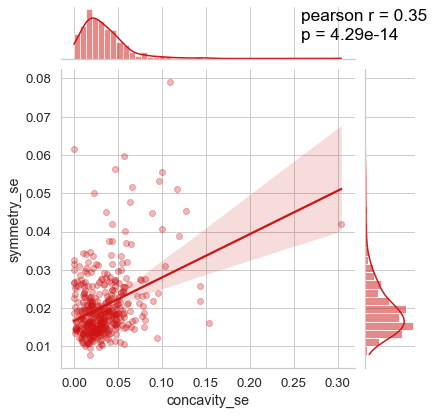

In [12]:
sns.set(style="whitegrid", palette="muted",font_scale = 1.2)
sns.jointplot(x.loc[:,'concavity_se'], x.loc[:,'symmetry_se'], kind="reg", color="#ce1414",scatter_kws={'alpha':0.3})
# add text annotation
plt.text(-100, 0.095, "pearson r = 0.35", horizontalalignment='left', size='large', color='black') 
plt.text(-100, 0.09, "p = 4.29e-14", horizontalalignment='left', size='large', color='black') 

# plt.text(-100, 0.49, "pearson r = 0.35", horizontalalignment='left', size='large', color='black') 
# plt.text(-100, 0.46, "p = 4.29e-14", horizontalalignment='left', size='large', color='black') 

* So both features will be used because the correlation is small.

In [13]:
# RF & XGB feature importances
x_new = x[['area_se','texture_mean','area_mean','smoothness_worst','concavity_worst','symmetry_worst','symmetry_se','concave points_se','concavity_se']]
x_new.head()

,area_se,texture_mean,area_mean,smoothness_worst,concavity_worst,symmetry_worst,symmetry_se,concave points_se,concavity_se
49,20.20,22.30,561.0,0.1162,0.228200,0.2871,0.01641,0.011840,0.02095
285,22.45,18.40,489.0,0.1038,0.005579,0.2505,0.02571,0.002924,0.00186
495,21.84,20.21,680.9,0.1216,0.170000,0.2369,0.01959,0.011830,0.02153
391,28.85,16.84,234.3,0.1460,0.000000,0.2445,0.01865,0.000000,0.00000
187,17.86,17.19,420.3,0.1323,0.152100,0.2572,0.01897,0.011850,0.01978


In [14]:
# https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/#:~:text=Given%20the%20improved%20estimate%20of,biased%20estimates%20of%20model%20performance.
# cv = LeaveOneOut()

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
cv=KFold(n_splits=10, shuffle=True, random_state=13)

originalclass = []
predictedclass = []

def classification_report_with_accuracy_score(y_true, y_pred):
  originalclass.extend(y_true)
  predictedclass.extend(y_pred)
  #print(classification_report(y_true, y_pred, target_names=target_names)) 
  return accuracy_score(y_true, y_pred)

def print_best_params(grid_search):
    print("")
    print("Best hyperparameters : ", grid_search.best_params_)
    print("")
    print("Best estimator : ", grid_search.best_estimator_)
    print("")

<a id='3'></a>
## 3) [Gaussian Naive Bayes](<https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB>)

* Default hyperparameters

In [18]:
# start = time.time()

originalclass = []
predictedclass = []
  
# Cross validate
clf_gnb = Pipeline([('scaler', StandardScaler()), ('gnb', GaussianNB())])
score = cross_val_score(clf_gnb, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

# end =  time.time()
# print('Run time = ',end - start)

              precision    recall  f1-score   support

      Benign      0.910     0.958     0.933       212
   Malignant      0.955     0.906     0.930       212

    accuracy                          0.932       424
   macro avg      0.933     0.932     0.932       424
weighted avg      0.933     0.932     0.932       424



* Hyperparameter tuning using Grid Search

In [29]:
param_grid = { 'gnb__var_smoothing': np.logspace(0,-10, num=100) }

grid_search = GridSearchCV(clf_gnb, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Best hyperparameters :  {'gnb__var_smoothing': 0.019179102616724886}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('gnb', GaussianNB(var_smoothing=0.019179102616724886))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gnb__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
19,0.006383,0.008889,0.012167,0.031189,0.012045,{'gnb__var_smoothing': 0.012045035402587823},0.952851,0.928847,0.927731,0.906926,0.976177,0.976068,0.901176,0.854167,0.902778,0.97551,0.930223,0.038352,1
18,0.011768,0.025672,0.002494,0.001561,0.015199,{'gnb__var_smoothing': 0.01519911082952934},0.952851,0.928847,0.927731,0.906926,0.976177,0.976068,0.901176,0.854167,0.902778,0.97551,0.930223,0.038352,1
17,0.003242,0.000509,0.001894,0.000537,0.019179,{'gnb__var_smoothing': 0.019179102616724886},0.952851,0.928847,0.927731,0.906926,0.976177,0.976068,0.901176,0.854167,0.902778,0.97551,0.930223,0.038352,1


* Tuned hyperparameters

In [30]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_gnb = Pipeline(steps=[('scaler', StandardScaler()),
                ('gnb', GaussianNB(var_smoothing=0.019179102616724886))])

score = cross_val_score(clf_gnb, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.907     0.962     0.934       212
   Malignant      0.960     0.901     0.929       212

    accuracy                          0.932       424
   macro avg      0.933     0.932     0.932       424
weighted avg      0.933     0.932     0.932       424



<a id='4'></a>
## 4) [Linear Discriminant Analysis](<https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html>)

* Default hyperparameters

In [31]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_lda = Pipeline([('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis())])

score = cross_val_score(clf_lda, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.913     0.995     0.953       212
   Malignant      0.995     0.906     0.948       212

    accuracy                          0.950       424
   macro avg      0.954     0.950     0.950       424
weighted avg      0.954     0.950     0.950       424



* Hyperparameter tuning using Grid Search

In [32]:
param_grid = {
    'lda__solver' : ['svd','lsqr','eigen'],
    'lda__shrinkage':[None,'auto'],
    'lda__tol': [0.0001,0.001,0.01,0.1]
}

grid_search = GridSearchCV(clf_lda, param_grid=param_grid, n_jobs=-1, cv=cv,verbose=4,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 24 candidates, totalling 240 fits

Best hyperparameters :  {'lda__shrinkage': None, 'lda__solver': 'svd', 'lda__tol': 0.0001}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis())])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lda__shrinkage,param_lda__solver,param_lda__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004887,0.001217,0.002146,0.000550,None,svd,0.0001,"{'lda__shrinkage': None, 'lda__solver': 'svd',...",0.883469,0.902715,0.904444,0.953261,0.976177,0.976068,0.973668,0.951389,0.97551,1.0,0.94967,0.037182,1
7,0.020595,0.043637,0.018203,0.038756,None,lsqr,0.1,"{'lda__shrinkage': None, 'lda__solver': 'lsqr'...",0.883469,0.902715,0.904444,0.953261,0.976177,0.976068,0.973668,0.951389,0.97551,1.0,0.94967,0.037182,1
11,0.004388,0.000662,0.027528,0.049832,None,eigen,0.1,"{'lda__shrinkage': None, 'lda__solver': 'eigen...",0.883469,0.902715,0.904444,0.953261,0.976177,0.976068,0.973668,0.951389,0.97551,1.0,0.94967,0.037182,1


* Tuned hyperparameters

In [33]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_lda = Pipeline([('scaler', StandardScaler()), ('lda', LinearDiscriminantAnalysis(shrinkage=None,solver='svd',tol=0.0001))])

score = cross_val_score(clf_lda, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.913     0.995     0.953       212
   Malignant      0.995     0.906     0.948       212

    accuracy                          0.950       424
   macro avg      0.954     0.950     0.950       424
weighted avg      0.954     0.950     0.950       424



<a id='5'></a>
## 5) [Quadratic Discriminant Analysis](<https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html>)

* Default hyperparameters

In [34]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_qda = Pipeline([('scaler', StandardScaler()), ('qda', QuadraticDiscriminantAnalysis())])

score = cross_val_score(clf_qda, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.940     0.958     0.949       212
   Malignant      0.957     0.939     0.948       212

    accuracy                          0.948       424
   macro avg      0.948     0.948     0.948       424
weighted avg      0.948     0.948     0.948       424



* Hyperparameter tuning using Grid Search

In [35]:
param_grid = {
    'qda__reg_param': np.linspace(0, 1, num=10),
    'qda__tol': [0.0001,0.001,0.01]
}

grid_search = GridSearchCV(clf_qda, param_grid=param_grid, n_jobs=-1, cv=cv,verbose=4,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 30 candidates, totalling 300 fits

Best hyperparameters :  {'qda__reg_param': 0.1111111111111111, 'qda__tol': 0.0001}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('qda',
                 QuadraticDiscriminantAnalysis(reg_param=0.1111111111111111))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_qda__reg_param,param_qda__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.016655,0.026601,0.001995,0.000773,0.111111,0.0001,"{'qda__reg_param': 0.1111111111111111, 'qda__t...",0.906522,0.976282,0.928847,0.930081,1.0,0.976068,0.948148,0.902778,0.927545,0.97551,0.947178,0.031486,1
4,0.036408,0.063829,0.012917,0.028514,0.111111,0.001,"{'qda__reg_param': 0.1111111111111111, 'qda__t...",0.906522,0.976282,0.928847,0.930081,1.0,0.976068,0.948148,0.902778,0.927545,0.97551,0.947178,0.031486,1
5,0.020696,0.043946,0.004243,0.002088,0.111111,0.01,"{'qda__reg_param': 0.1111111111111111, 'qda__t...",0.906522,0.976282,0.928847,0.930081,1.0,0.976068,0.948148,0.902778,0.927545,0.97551,0.947178,0.031486,1


* Tuned hyperparameters

In [36]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_qda = Pipeline([('scaler', StandardScaler()), ('qda', QuadraticDiscriminantAnalysis(reg_param=0.1111111111111111))])

score = cross_val_score(clf_qda, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.917     0.986     0.950       212
   Malignant      0.985     0.910     0.946       212

    accuracy                          0.948       424
   macro avg      0.951     0.948     0.948       424
weighted avg      0.951     0.948     0.948       424



<a id='6'></a>
## 6) [Ridge Classifier](<https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier>)

* Default hyperparameters

In [37]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_rc = Pipeline([('scaler', StandardScaler()), ('rg', RidgeClassifier())])

score = cross_val_score(clf_rc, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.913     0.995     0.953       212
   Malignant      0.995     0.906     0.948       212

    accuracy                          0.950       424
   macro avg      0.954     0.950     0.950       424
weighted avg      0.954     0.950     0.950       424



* Hyperparameter tuning using Grid Search

In [38]:
param_grid = {
    'rg__alpha' : np.linspace(0, 1, num=10),
    'rg__fit_intercept' : [True,False],
    'rg__copy_X' : [True,False],
    'rg__max_iter' : [None],
    'rg__tol' : [0.001],
    'rg__class_weight' : [None,'balanced'],
    'rg__solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'rg__positive' : [False]
}

grid_search = GridSearchCV(clf_rc, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 560 candidates, totalling 5600 fits

Best hyperparameters :  {'rg__alpha': 0.0, 'rg__class_weight': None, 'rg__copy_X': True, 'rg__fit_intercept': False, 'rg__max_iter': None, 'rg__positive': False, 'rg__solver': 'svd', 'rg__tol': 0.001}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('rg',
                 RidgeClassifier(alpha=0.0, fit_intercept=False,
                                 solver='svd'))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rg__alpha,param_rg__class_weight,param_rg__copy_X,param_rg__fit_intercept,param_rg__max_iter,param_rg__positive,param_rg__solver,param_rg__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
558,0.015359,0.025988,0.003291,0.003155,1.0,balanced,False,False,None,False,saga,0.001,"{'rg__alpha': 1.0, 'rg__class_weight': 'balanc...",0.906522,0.902715,0.904444,0.953261,0.976177,0.976068,0.973668,0.951389,0.97551,1.0,0.951975,0.033542,1
445,0.005386,0.000914,0.012019,0.030079,0.777778,balanced,False,False,None,False,sag,0.001,"{'rg__alpha': 0.7777777777777777, 'rg__class_w...",0.906522,0.902715,0.904444,0.953261,0.976177,0.976068,0.973668,0.951389,0.97551,1.0,0.951975,0.033542,1
233,0.004588,0.000489,0.002095,0.000299,0.444444,None,True,False,None,False,lsqr,0.001,"{'rg__alpha': 0.4444444444444444, 'rg__class_w...",0.906522,0.902715,0.904444,0.953261,0.976177,0.976068,0.973668,0.951389,0.97551,1.0,0.951975,0.033542,1


* Tuned hyperparameters

In [39]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_rc = Pipeline([('scaler', StandardScaler()), 
                    ('rg', RidgeClassifier(alpha=0.0,fit_intercept=False,solver='svd'))])

score = cross_val_score(clf_rc, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.917     0.995     0.955       212
   Malignant      0.995     0.910     0.951       212

    accuracy                          0.953       424
   macro avg      0.956     0.953     0.953       424
weighted avg      0.956     0.953     0.953       424



<a id='7'></a>
## 7) [Decision Tree Classifier](<https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html>)

* Default hyperparameters

In [40]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_tree = Pipeline([('scaler', StandardScaler()), ('tree', DecisionTreeClassifier(random_state=13))])

score = cross_val_score(clf_tree, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.928     0.915     0.922       212
   Malignant      0.916     0.929     0.923       212

    accuracy                          0.922       424
   macro avg      0.922     0.922     0.922       424
weighted avg      0.922     0.922     0.922       424



* Hyperparameter tuning using Grid Search

In [41]:
param_grid = {
    'tree__criterion' :['gini','entropy'],
    'tree__splitter' : ['best','random'],
    'tree__max_depth': [2,6,10,None],
    'tree__min_samples_split': list(range(2, 4)),
    'tree__min_samples_leaf': [3,5],
    'tree__min_weight_fraction_leaf' : [0.0],
    'tree__max_features': [None, 'sqrt', 'log2'],
    'tree__max_leaf_nodes' : [None,10,50],
    'tree__min_impurity_decrease' : [0.0],
    'tree__class_weight' : [None,'balanced'],
    'tree__ccp_alpha' : [0.0],
    'tree__random_state' : [13]
}

grid_search = GridSearchCV(clf_tree, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits

Best hyperparameters :  {'tree__ccp_alpha': 0.0, 'tree__class_weight': None, 'tree__criterion': 'gini', 'tree__max_depth': 10, 'tree__max_features': None, 'tree__max_leaf_nodes': 10, 'tree__min_impurity_decrease': 0.0, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 2, 'tree__min_weight_fraction_leaf': 0.0, 'tree__random_state': 13, 'tree__splitter': 'random'}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10,
                                        min_samples_leaf=3, random_state=13,
                                        splitter='random'))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__ccp_alpha,param_tree__class_weight,param_tree__criterion,param_tree__max_depth,param_tree__max_features,param_tree__max_leaf_nodes,param_tree__min_impurity_decrease,param_tree__min_samples_leaf,param_tree__min_samples_split,param_tree__min_weight_fraction_leaf,param_tree__random_state,param_tree__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
153,0.004089,0.001575,0.002294,0.000640,0.0,None,gini,10,None,10,0.0,3,2,0.0,13,random,"{'tree__ccp_alpha': 0.0, 'tree__class_weight':...",0.97591,0.86039,0.904444,0.881412,0.928205,0.952381,1.0,0.928205,0.950588,0.975045,0.935658,0.041842,1
155,0.004688,0.002094,0.011668,0.028360,0.0,None,gini,10,None,10,0.0,3,3,0.0,13,random,"{'tree__ccp_alpha': 0.0, 'tree__class_weight':...",0.97591,0.86039,0.904444,0.881412,0.928205,0.952381,1.0,0.928205,0.950588,0.975045,0.935658,0.041842,1
225,0.003590,0.000798,0.001895,0.000698,0.0,None,gini,None,None,10,0.0,3,2,0.0,13,random,"{'tree__ccp_alpha': 0.0, 'tree__class_weight':...",0.97591,0.86039,0.904444,0.881412,0.928205,0.952381,1.0,0.928205,0.950588,0.975045,0.935658,0.041842,1


* Tuned hyperparameters

In [42]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_tree = Pipeline(steps=[('scaler', StandardScaler()),
                ('tree', DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10,
                                        min_samples_leaf=3, random_state=13,
                                        splitter='random'))])

score = cross_val_score(clf_tree, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.947     0.925     0.936       212
   Malignant      0.926     0.948     0.937       212

    accuracy                          0.936       424
   macro avg      0.937     0.936     0.936       424
weighted avg      0.937     0.936     0.936       424



<a id='8'></a>
## 8) [Random Forest Classifier](<https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>)

* Default hyperparameters

In [62]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=13))])
                       
score = cross_val_score(clf_rf, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.962     0.962     0.962       212
   Malignant      0.962     0.962     0.962       212

    accuracy                          0.962       424
   macro avg      0.962     0.962     0.962       424
weighted avg      0.962     0.962     0.962       424



* Hyperparameter tuning using Grid Search

In [63]:
param_grid = {
    'rf__bootstrap': [True,False],
    'rf__max_depth': [5, 10 , None],
    'rf__n_estimators' : [10,50,100,200,500], 
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__max_leaf_nodes' : [None,5,10],
    'rf__min_samples_leaf': [1,3,5],
    'rf__min_samples_split': list(range(2, 6)),
    'rf__criterion' :['entropy','gini'],
    'rf__random_state' : [13]
}

grid_search = GridSearchCV(clf_rf, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 6480 candidates, totalling 64800 fits

Best hyperparameters :  {'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 500, 'rf__random_state': 13}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=500, random_state=13))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__bootstrap,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__max_leaf_nodes,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1809,2.881691,0.065597,0.226494,0.067233,True,gini,5,sqrt,None,1,3,500,13,"{'rf__bootstrap': True, 'rf__criterion': 'gini...",1.0,0.930081,0.952851,0.953261,0.952381,0.952273,0.974437,0.951945,1.0,1.0,0.966723,0.023939,1
1804,1.620066,1.053971,0.147106,0.118144,True,gini,5,sqrt,None,1,2,500,13,"{'rf__bootstrap': True, 'rf__criterion': 'gini...",1.0,0.930081,0.952851,0.953261,0.952381,0.952273,0.974437,0.951945,1.0,1.0,0.966723,0.023939,1
1984,1.636777,1.130437,0.096731,0.066522,True,gini,5,log2,None,1,2,500,13,"{'rf__bootstrap': True, 'rf__criterion': 'gini...",1.0,0.930081,0.952851,0.953261,0.952381,0.952273,0.974437,0.951945,1.0,1.0,0.966723,0.023939,1


* Tuned hyperparameters

In [68]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_rf = Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=5,max_features='sqrt',max_leaf_nodes=None,
                                        min_samples_leaf=1,min_samples_split=3,n_estimators=500,
                                        random_state=13))])
                       
score = cross_val_score(clf_rf, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.971     0.962     0.967       212
   Malignant      0.963     0.972     0.967       212

    accuracy                          0.967       424
   macro avg      0.967     0.967     0.967       424
weighted avg      0.967     0.967     0.967       424



<a id='9'></a>
## 9) [ADA Boost Classifier (Adaptive Boosting)](<https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.>)

* Default hyperparameters

In [43]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_adaboost = Pipeline([('scaler', StandardScaler()), ('adab', AdaBoostClassifier(random_state=13))])

score = cross_val_score(clf_adaboost, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.967     0.962     0.965       212
   Malignant      0.962     0.967     0.965       212

    accuracy                          0.965       424
   macro avg      0.965     0.965     0.965       424
weighted avg      0.965     0.965     0.965       424



* Hyperparameter tuning using Grid Search

In [44]:
param_grid = {
    'adab__base_estimator' : [DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10,min_samples_leaf=3, random_state=13,splitter='random')],
    'adab__n_estimators' : [10,50,100,500],
    'adab__learning_rate' : np.power(10, np.arange(-3, 1, dtype=float)),
    'adab__algorithm' : ['SAMME', 'SAMME.R'],
    'adab__random_state' : [13],
}

grid_search = GridSearchCV(clf_adaboost, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 32 candidates, totalling 320 fits

Best hyperparameters :  {'adab__algorithm': 'SAMME.R', 'adab__base_estimator': DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=3,
                       random_state=13, splitter='random'), 'adab__learning_rate': 1.0, 'adab__n_estimators': 500, 'adab__random_state': 13}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('adab',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                          max_leaf_nodes=10,
                                                                          min_samples_leaf=3,
                                                                          random_state=13,
                                                                          splitter='random'),
                                    n_estimators=500, random_state=13))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adab__algorithm,param_adab__base_estimator,param_adab__learning_rate,param_adab__n_estimators,param_adab__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
31,1.015290,0.497745,0.077498,0.040036,SAMME.R,"DecisionTreeClassifier(max_depth=10, max_leaf_...",1.0,500,13,"{'adab__algorithm': 'SAMME.R', 'adab__base_est...",0.976282,0.952851,0.952851,0.906522,1.000000,0.952273,1.000000,0.951389,1.0,0.97551,0.966768,0.028185,1
30,0.215333,0.152803,0.024286,0.029982,SAMME.R,"DecisionTreeClassifier(max_depth=10, max_leaf_...",1.0,100,13,"{'adab__algorithm': 'SAMME.R', 'adab__base_est...",0.976282,0.952851,0.928847,0.929624,0.976177,0.928531,1.000000,0.975848,1.0,0.97551,0.964367,0.026386,2
15,2.023490,0.913673,0.121629,0.083330,SAMME,"DecisionTreeClassifier(max_depth=10, max_leaf_...",1.0,500,13,"{'adab__algorithm': 'SAMME', 'adab__base_estim...",0.952851,0.976541,0.952851,0.952851,0.976177,0.928531,0.974437,0.951945,1.0,0.97551,0.964169,0.019024,3


* Tuned hyperparameters

In [45]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_adaboost = Pipeline(steps=[('scaler', StandardScaler()),
                ('adab',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                          max_leaf_nodes=10,
                                                                          min_samples_leaf=3,
                                                                          random_state=13,
                                                                          splitter='random'),
                                    n_estimators=500, random_state=13))])

score = cross_val_score(clf_adaboost, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.954     0.981     0.967       212
   Malignant      0.981     0.953     0.967       212

    accuracy                          0.967       424
   macro avg      0.967     0.967     0.967       424
weighted avg      0.967     0.967     0.967       424



<a id='10'></a>
## 10) [C-Support Vector Classification](<https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html>)

* Default hyperparameters

In [46]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

score = cross_val_score(clf_svc, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.963     0.981     0.972       212
   Malignant      0.981     0.962     0.971       212

    accuracy                          0.972       424
   macro avg      0.972     0.972     0.972       424
weighted avg      0.972     0.972     0.972       424



* Hyperparameter tuning using Grid Search

In [47]:
param_grid = [
    {
        'svc__kernel': ['rbf'], 
        'svc__gamma': [1e-2, 1e-3, 1e-4,'auto','scale'], 
        'svc__C': [1, 10, 100, 1000],
        'svc__decision_function_shape': ['ovo', 'ovr'],
        'svc__random_state' : [13]
    },
    {
        'svc__kernel': ['linear'], 
        'svc__C': [1, 10, 100, 1000],
        'svc__decision_function_shape': ['ovo', 'ovr'],
        'svc__random_state' : [13]
    },
]

grid_search = GridSearchCV(clf_svc, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 48 candidates, totalling 480 fits

Best hyperparameters :  {'svc__C': 1, 'svc__decision_function_shape': 'ovo', 'svc__kernel': 'linear', 'svc__random_state': 13}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=1, decision_function_shape='ovo', kernel='linear',
                     random_state=13))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__decision_function_shape,param_svc__gamma,param_svc__kernel,param_svc__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
40,0.017553,0.033476,0.002394,0.000798,1,ovo,NaN,linear,13,"{'svc__C': 1, 'svc__decision_function_shape': ...",0.952851,0.976282,0.952851,0.976541,1.0,0.976068,0.973668,0.975848,1.0,1.0,0.978411,0.016576,1
41,0.017154,0.035210,0.002693,0.000898,1,ovr,NaN,linear,13,"{'svc__C': 1, 'svc__decision_function_shape': ...",0.952851,0.976282,0.952851,0.976541,1.0,0.976068,0.973668,0.975848,1.0,1.0,0.978411,0.016576,1
45,0.037601,0.040200,0.010670,0.023069,100,ovr,NaN,linear,13,"{'svc__C': 100, 'svc__decision_function_shape'...",0.929624,0.952851,0.929624,0.976541,1.0,0.976068,1.000000,0.975848,1.0,1.0,0.974056,0.026653,3


* Tuned hyperparameters

In [48]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_svc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',SVC(C=1, decision_function_shape='ovo', kernel='linear',
                     random_state=13))])

score = cross_val_score(clf_svc, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.963     0.995     0.979       212
   Malignant      0.995     0.962     0.978       212

    accuracy                          0.979       424
   macro avg      0.979     0.979     0.979       424
weighted avg      0.979     0.979     0.979       424



<a id='11'></a>
## 11) [Stochastic Gradient Descent Classifier](<https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html>)

* Default hyperparameters

In [49]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_sgd = Pipeline([('scaler', StandardScaler()), ('sgd', SGDClassifier(random_state=13))])

score = cross_val_score(clf_sgd, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.953     0.953     0.953       212
   Malignant      0.953     0.953     0.953       212

    accuracy                          0.953       424
   macro avg      0.953     0.953     0.953       424
weighted avg      0.953     0.953     0.953       424



* Hyperparameter tuning using Grid Search

In [50]:
param_grid = {
    'sgd__average': [True, False],
    'sgd__l1_ratio': np.linspace(0, 1, num=10),
    'sgd__alpha': np.power(10, np.arange(-2, 1, dtype=float)),
    'sgd__random_state' : [13]
}

grid_search = GridSearchCV(clf_sgd, param_grid=param_grid, n_jobs=-1, cv=cv,verbose=4,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 60 candidates, totalling 600 fits

Best hyperparameters :  {'sgd__alpha': 0.01, 'sgd__average': True, 'sgd__l1_ratio': 0.0, 'sgd__random_state': 13}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.01, average=True, l1_ratio=0.0,
                               random_state=13))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgd__alpha,param_sgd__average,param_sgd__l1_ratio,param_sgd__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014162,0.023743,0.002094,0.001296,0.01,True,0.0,13,"{'sgd__alpha': 0.01, 'sgd__average': True, 'sg...",0.929624,0.976282,0.952851,0.976541,1.0,0.976068,0.974437,0.975848,1.0,1.0,0.976165,0.021017,1
2,0.016905,0.027544,0.001795,0.000599,0.01,True,0.222222,13,"{'sgd__alpha': 0.01, 'sgd__average': True, 'sg...",0.929624,0.976282,0.952851,0.976541,1.0,0.976068,0.974437,0.975848,1.0,1.0,0.976165,0.021017,1
3,0.025334,0.043777,0.001995,0.001338,0.01,True,0.333333,13,"{'sgd__alpha': 0.01, 'sgd__average': True, 'sg...",0.929624,0.976282,0.952851,0.976541,1.0,0.976068,0.974437,0.975848,1.0,1.0,0.976165,0.021017,1


* Tuned hyperparameters

In [51]:
originalclass = []
predictedclass = []

# Cross validate
clf_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',SGDClassifier(alpha=0.01, average=True, l1_ratio=0.0,
                               random_state=13))])

score = cross_val_score(clf_sgd, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.963     0.991     0.977       212
   Malignant      0.990     0.962     0.976       212

    accuracy                          0.976       424
   macro avg      0.977     0.976     0.976       424
weighted avg      0.977     0.976     0.976       424



<a id='12'></a>
## 12) [eXtreme Gradient Boosting](<https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters>)

* Default hyperparameters

In [64]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_xgb = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier(random_state=13))])

score = cross_val_score(clf_xgb, x_new, y_le, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.957     0.948     0.953       212
   Malignant      0.949     0.958     0.953       212

    accuracy                          0.953       424
   macro avg      0.953     0.953     0.953       424
weighted avg      0.953     0.953     0.953       424



* Hyperparameter tuning using Grid Search

In [65]:
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
# https://www.cs.cornell.edu/courses/cs4780/2018sp/lectures/lecturenote19.html
# https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6

param_grid = {
        'xgb__booster' : ['gbtree'],
        'xgb__validate_parameters' : [True],
        'xgb__learning_rate' : [0.05,0.1,0.3,0.5,1],
        'xgb__gamma' : [0,0.01,0.1,0.5,1],
        'xgb__max_depth' : [2,6,10],
        'xgb__min_child_weight' : [1,3,5],
        'xgb__max_delta_step' : [0,2,4],
        'xgb__subsample' : [0.5],
        'xgb__colsample_bylevel' : [1],
        'xgb__colsample_bynode' : [1],
        'xgb__colsample_bytree' : [1],
        'xgb__reg_lambda' : [0,1],
        'xgb__reg_alpha' : [0],
        'xgb__tree_method' : ['exact'],
        'xgb__scale_pos_weight' : [1],
        'xgb__objective' : ['binary:logistic'], # 'multi:softmax' -> same scores as 'binary:logistic'
        #'num_class' : [2],
        'xgb__n_estimators' : [50,100,200,500],
        'xgb__random_state' : [13]
    }

grid_search = GridSearchCV(clf_xgb, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y_le)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 5400 candidates, totalling 54000 fits

Best hyperparameters :  {'xgb__booster': 'gbtree', 'xgb__colsample_bylevel': 1, 'xgb__colsample_bynode': 1, 'xgb__colsample_bytree': 1, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.3, 'xgb__max_delta_step': 0, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 100, 'xgb__objective': 'binary:logistic', 'xgb__random_state': 13, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.5, 'xgb__tree_method': 'exact', 'xgb__validate_parameters': True}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gam

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__booster,param_xgb__colsample_bylevel,param_xgb__colsample_bynode,param_xgb__colsample_bytree,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_delta_step,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__objective,param_xgb__random_state,param_xgb__reg_alpha,param_xgb__reg_lambda,param_xgb__scale_pos_weight,param_xgb__subsample,param_xgb__tree_method,param_xgb__validate_parameters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2763,0.224158,0.037730,0.003741,0.000871,gbtree,1,1,1,0.1,0.3,4,6,1,100,binary:logistic,13,0,1,1,0.5,exact,True,"{'xgb__booster': 'gbtree', 'xgb__colsample_byl...",0.976282,0.905702,0.952851,0.952851,0.976177,0.952273,1.0,0.975848,1.0,1.0,0.969198,0.028004,1
2715,0.266004,0.079994,0.004886,0.002693,gbtree,1,1,1,0.1,0.3,2,10,1,100,binary:logistic,13,0,1,1,0.5,exact,True,"{'xgb__booster': 'gbtree', 'xgb__colsample_byl...",0.976282,0.905702,0.952851,0.952851,0.976177,0.952273,1.0,0.975848,1.0,1.0,0.969198,0.028004,1
2643,0.144546,0.057605,0.003100,0.000305,gbtree,1,1,1,0.1,0.3,0,10,1,100,binary:logistic,13,0,1,1,0.5,exact,True,"{'xgb__booster': 'gbtree', 'xgb__colsample_byl...",0.976282,0.905702,0.952851,0.952851,0.976177,0.952273,1.0,0.975848,1.0,1.0,0.969198,0.028004,1


* Tuned hyperparameters

In [67]:
originalclass = []
predictedclass = []

# Cross validate
clf_xgb = Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',XGBClassifier(booster='gbtree',gamma=0.1,learning_rate=0.3,max_delta_step=4,max_depth=6,min_child_weight=1,
                                    n_estimators=100,objective='binary:logistic',reg_alpha=0,reg_lambda=1,scale_pos_weight=1,subsample=0.5,
                                    tree_method='exact',validate_parameters=True,random_state=13))])

score = cross_val_score(clf_xgb, x_new, y_le, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.967     0.972     0.969       212
   Malignant      0.972     0.967     0.969       212

    accuracy                          0.969       424
   macro avg      0.969     0.969     0.969       424
weighted avg      0.969     0.969     0.969       424



<a id='13'></a>
## 13) [Light Gradient Boosting Machine](<https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html>)

* Default hyperparameters

In [59]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_lgbm = Pipeline([('scaler', StandardScaler()), ('lgbm', lgbm.LGBMClassifier(random_state=13))])

score = cross_val_score(clf_lgbm, x_new, y_le, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.957     0.953     0.955       212
   Malignant      0.953     0.958     0.955       212

    accuracy                          0.955       424
   macro avg      0.955     0.955     0.955       424
weighted avg      0.955     0.955     0.955       424



* Hyperparameter tuning using Grid Search

In [60]:
# https://neptune.ai/blog/lightgbm-parameters-guide
# https://www.youtube.com/watch?v=5CWwwtEM2TA&ab_channel=PyData & https://github.com/MSusik/newgradientboosting/blob/master/pydata.pdf

param_grid = {
        'lgbm__boosting_type' : ['gbdt','dart'],
        'lgbm__num_leaves' : [10,20,30,40,50],
        'lgbm__max_depth' : [3,6,9,-1],
        'lgbm__learning_rate' : [0.05,0.1,0.3,0.5,1],
        'lgbm__n_estimators' : [50,100,200,500],
        'lgbm__objective' : ['binary'],
        'lgbm__min_child_samples' : [10,20,30],
        'lgbm__subsample' : [0.5],
        'lgbm__reg_lambda' : [0,1],
        'lgbm__reg_alpha' : [0],
        'lgbm__subsample' : [0.5],
        'lgbm__colsample_bytree' : [1],
        'lgbm__scale_pos_weight' : [1],
        'lgbm__random_state' : [13]
    }

grid_search = GridSearchCV(clf_lgbm, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y_le)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 4800 candidates, totalling 48000 fits

Best hyperparameters :  {'lgbm__boosting_type': 'gbdt', 'lgbm__colsample_bytree': 1, 'lgbm__learning_rate': 1, 'lgbm__max_depth': 3, 'lgbm__min_child_samples': 10, 'lgbm__n_estimators': 50, 'lgbm__num_leaves': 10, 'lgbm__objective': 'binary', 'lgbm__random_state': 13, 'lgbm__reg_alpha': 0, 'lgbm__reg_lambda': 0, 'lgbm__scale_pos_weight': 1, 'lgbm__subsample': 0.5}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('lgbm',
                 LGBMClassifier(colsample_bytree=1, learning_rate=1,
                                max_depth=3, min_child_samples=10,
                                n_estimators=50, num_leaves=10,
                                objective='binary', random_state=13,
                                reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
                                subsample=0.5))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__boosting_type,param_lgbm__colsample_bytree,param_lgbm__learning_rate,param_lgbm__max_depth,param_lgbm__min_child_samples,param_lgbm__n_estimators,param_lgbm__num_leaves,param_lgbm__objective,param_lgbm__random_state,param_lgbm__reg_alpha,param_lgbm__reg_lambda,param_lgbm__scale_pos_weight,param_lgbm__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1922,0.009973,0.001180,0.001695,0.000457,gbdt,1,1,3,10,50,20,binary,13,0,0,1,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",0.952222,0.930081,0.976282,0.952851,1.0,0.952273,0.974437,0.975848,0.97551,0.97551,0.966502,0.018573,1
1926,0.010372,0.001850,0.001696,0.000457,gbdt,1,1,3,10,50,40,binary,13,0,0,1,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",0.952222,0.930081,0.976282,0.952851,1.0,0.952273,0.974437,0.975848,0.97551,0.97551,0.966502,0.018573,1
1928,0.011070,0.002729,0.001596,0.000488,gbdt,1,1,3,10,50,50,binary,13,0,0,1,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__colsamp...",0.952222,0.930081,0.976282,0.952851,1.0,0.952273,0.974437,0.975848,0.97551,0.97551,0.966502,0.018573,1


* Tuned hyperparameters

In [61]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_lgbm = Pipeline(steps=[('scaler', StandardScaler()),
                ('lgbm',lgbm.LGBMClassifier(colsample_bytree=1, learning_rate=1,
                                max_depth=3, min_child_samples=10,
                                n_estimators=50, num_leaves=10,
                                objective='binary', random_state=13,
                                reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
                                subsample=0.5))])

score = cross_val_score(clf_lgbm, x_new, y_le, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.967     0.967     0.967       212
   Malignant      0.967     0.967     0.967       212

    accuracy                          0.967       424
   macro avg      0.967     0.967     0.967       424
weighted avg      0.967     0.967     0.967       424



<a id='14'></a>
## 14) [K-Nearest Neighbors Classifier](<https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html>)

* Default hyperparameters

In [52]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

score = cross_val_score(clf_knn, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.932     0.967     0.949       212
   Malignant      0.966     0.929     0.947       212

    accuracy                          0.948       424
   macro avg      0.949     0.948     0.948       424
weighted avg      0.949     0.948     0.948       424



* Hyperparameter tuning using Grid Search

In [53]:
param_grid = {
    'knn__n_neighbors': list(range(2,10)),
    'knn__weights': ['uniform','distance'],
    'knn__algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10,20,30,40,50],
    'knn__p': [1,2],
    'knn__metric': ['minkowski','manhattan','chebyshev']
}

grid_search = GridSearchCV(clf_knn, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=False).head(3)

Fitting 10 folds for each of 1440 candidates, totalling 14400 fits

Best hyperparameters :  {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 10, 'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=10,
                                      n_neighbors=3, p=1))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__algorithm,param_knn__leaf_size,param_knn__metric,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
612,0.020396,0.034591,0.003291,0.000457,kd_tree,20,manhattan,3,1,uniform,"{'knn__algorithm': 'kd_tree', 'knn__leaf_size'...",0.952851,0.952851,0.952851,0.953261,0.976177,0.976177,0.974437,0.927545,1.0,0.951389,0.961754,0.019045,1
711,0.011369,0.023501,0.013216,0.030362,kd_tree,30,manhattan,3,2,distance,"{'knn__algorithm': 'kd_tree', 'knn__leaf_size'...",0.952851,0.952851,0.952851,0.953261,0.976177,0.976177,0.974437,0.927545,1.0,0.951389,0.961754,0.019045,1
293,0.010572,0.021751,0.011421,0.025623,ball_tree,40,minkowski,3,1,distance,"{'knn__algorithm': 'ball_tree', 'knn__leaf_siz...",0.952851,0.952851,0.952851,0.953261,0.976177,0.976177,0.974437,0.927545,1.0,0.951389,0.961754,0.019045,1


* Tuned hyperparameters

In [54]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_knn = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',KNeighborsClassifier(algorithm='ball_tree', leaf_size=10,
                                      n_neighbors=3, p=1))])

score = cross_val_score(clf_knn, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.950     0.976     0.963       212
   Malignant      0.976     0.948     0.962       212

    accuracy                          0.962       424
   macro avg      0.963     0.962     0.962       424
weighted avg      0.963     0.962     0.962       424



<a id='15'></a>
## 15) [Multi-layer Perceptron Classifier](<https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html>)

* Default hyperparameters

In [55]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_mlp =  Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(random_state=13))])

score = cross_val_score(clf_mlp, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.967     0.972     0.969       212
   Malignant      0.972     0.967     0.969       212

    accuracy                          0.969       424
   macro avg      0.969     0.969     0.969       424
weighted avg      0.969     0.969     0.969       424



* Hyperparameter tuning using Grid Search

In [56]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
param_grid = {
    'mlp__hidden_layer_sizes' : [(18,36,)],
    'mlp__activation' : ['tanh','relu'],
    'mlp__solver' : ['sgd','adam'],
    'mlp__alpha' : [0.01,0,2],
    'mlp__batch_size' : [40,80,'auto'],
    'mlp__learning_rate' : ['invscaling','adaptive'],
    'mlp__learning_rate_init' : np.power(10, np.arange(-3, 0, dtype=float)),
    'mlp__power_t' : [0.5],
    'mlp__max_iter' : [50,100,200,500],
    'mlp__shuffle' : [True],
    'mlp__random_state' : [13]
}

grid_search = GridSearchCV(clf_mlp, param_grid=param_grid, n_jobs=-1,cv=cv,verbose=1,scoring='f1_macro')
grid_search.fit(x_new, y)

print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='rank_test_score').head(3)

Fitting 10 folds for each of 864 candidates, totalling 8640 fits

Best hyperparameters :  {'mlp__activation': 'relu', 'mlp__alpha': 2, 'mlp__batch_size': 'auto', 'mlp__hidden_layer_sizes': (18, 36), 'mlp__learning_rate': 'invscaling', 'mlp__learning_rate_init': 0.1, 'mlp__max_iter': 50, 'mlp__power_t': 0.5, 'mlp__random_state': 13, 'mlp__shuffle': True, 'mlp__solver': 'adam'}

Best estimator :  Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(alpha=2, hidden_layer_sizes=(18, 36),
                               learning_rate='invscaling',
                               learning_rate_init=0.1, max_iter=50,
                               random_state=13))])



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__batch_size,param_mlp__hidden_layer_sizes,param_mlp__learning_rate,param_mlp__learning_rate_init,param_mlp__max_iter,param_mlp__power_t,param_mlp__random_state,param_mlp__shuffle,param_mlp__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
857,0.139527,0.020760,0.002294,0.000639,relu,2,auto,"(18, 36)",adaptive,0.1,50,0.5,13,True,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 2, '...",1.0,0.976282,0.929624,0.976541,1.0,0.976068,1.0,0.975848,1.0,1.0,0.983436,0.021162,1
833,0.077293,0.020774,0.002793,0.002515,relu,2,auto,"(18, 36)",invscaling,0.1,50,0.5,13,True,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 2, '...",1.0,0.976282,0.929624,0.976541,1.0,0.976068,1.0,0.975848,1.0,1.0,0.983436,0.021162,1
863,0.096143,0.031924,0.001995,0.000446,relu,2,auto,"(18, 36)",adaptive,0.1,500,0.5,13,True,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 2, '...",1.0,0.976282,0.929624,0.953261,1.0,0.976068,1.0,0.975848,1.0,1.0,0.981108,0.022993,3


* Tuned hyperparameters

In [57]:
originalclass = []
predictedclass = []
  
# Cross validate
clf_mlp =  Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',MLPClassifier(alpha=2, hidden_layer_sizes=(18, 36),
                               learning_rate='invscaling',
                               learning_rate_init=0.1, max_iter=50,
                               random_state=13))])


score = cross_val_score(clf_mlp, x_new, y, scoring=make_scorer(classification_report_with_accuracy_score),cv=cv)
print(classification_report(originalclass, predictedclass, target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Benign      0.977     0.991     0.984       212
   Malignant      0.990     0.976     0.983       212

    accuracy                          0.983       424
   macro avg      0.984     0.983     0.983       424
weighted avg      0.984     0.983     0.983       424



* Tried a larger range of hyperparameters for testing at first, but was too time consuming. The worst attempts were then found with the following code and the hyperparameters corresponding to those results were removed.

In [58]:
# print_best_params(grid_search)
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results.sort_values(by='mean_test_score',ascending=True).head(5) # worst 5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__batch_size,param_mlp__hidden_layer_sizes,param_mlp__learning_rate,param_mlp__learning_rate_init,param_mlp__max_iter,param_mlp__power_t,param_mlp__random_state,param_mlp__shuffle,param_mlp__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
96,0.099636,0.048215,0.001696,0.000457,tanh,0.01,auto,"(18, 36)",invscaling,0.001,50,0.5,13,True,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.01...",0.495514,0.351475,0.417488,0.464469,0.481481,0.371347,0.377778,0.442971,0.373134,0.489879,0.426554,0.052430,862
384,0.094148,0.029374,0.001795,0.000399,tanh,2,auto,"(18, 36)",invscaling,0.001,50,0.5,13,True,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 2, '...",0.495514,0.351475,0.417488,0.464469,0.481481,0.371347,0.377778,0.442971,0.373134,0.489879,0.426554,0.052430,862
240,0.088669,0.055544,0.002094,0.000299,tanh,0,auto,"(18, 36)",invscaling,0.001,50,0.5,13,True,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 0, '...",0.495514,0.351475,0.417488,0.464469,0.481481,0.371347,0.377778,0.442971,0.373134,0.489879,0.426554,0.052430,862
246,0.183770,0.054772,0.002194,0.001163,tanh,0,auto,"(18, 36)",invscaling,0.001,500,0.5,13,True,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 0, '...",0.495514,0.351475,0.417488,0.511364,0.481481,0.371347,0.412051,0.442971,0.489879,0.489879,0.446345,0.053212,853
388,0.173391,0.047324,0.001795,0.000598,tanh,2,auto,"(18, 36)",invscaling,0.001,200,0.5,13,True,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 2, '...",0.495514,0.351475,0.417488,0.511364,0.481481,0.371347,0.412051,0.442971,0.489879,0.489879,0.446345,0.053212,853


<a id='16'></a>
## 16) Summary

* Below are the tables of the specific feature selection method.
* The performance of the algorithms is in descending order.
* All the results are the average values of a 10-fold cross validation.
* The columns contain the accuracy and the average values of precision, recall and f1 score.
* It is observed that the number of samples of Βenign and Μalignant cancer are equal (212 respectively), so the weighted average and the macro average are equal.

<table>
    <tr>
        <th colspan="5"> RF & XGB feature importances : Default algorithms</th>
    </tr>
    <tr>
        <th></th>
        <th>precision </th>
        <th>recall</th>
        <th>f1 score</th>
        <th>accuracy</th>  
    </tr>
    <tr>
        <th>SVC</th>
        <td>0.972</td>
        <td>0.972</td>
        <td>0.972</td>
        <td>0.972</td>
    </tr>
    <tr>
        <th>MLP</th>
        <td>0.969</td>
        <td>0.969</td>
        <td>0.969</td>
        <td>0.969</td>
    </tr>
    <tr>
        <th>AdaBoost</th>
        <td>0.965</td>
        <td>0.965</td>
        <td>0.965</td>
        <td>0.965</td>
    </tr>
    <tr>
        <th>Random Forest</th>
        <td>0.962</td>
        <td>0.962</td>
        <td>0.962</td>
        <td>0.962</td>
    </tr>
    <tr>
        <th>LGBM</th>
        <td>0.955</td>
        <td>0.955</td>
        <td>0.955</td>
        <td>0.955</td>
    </tr>
    <tr>
        <th>SGD</th>
        <td>0.953</td>
        <td>0.953</td>
        <td>0.953</td>
        <td>0.953</td>
    </tr>
    <tr>
        <th>XGBoost</th>
        <td>0.953</td>
        <td>0.953</td>
        <td>0.953</td>
        <td>0.953</td>
    </tr>
    <tr>
        <th>Ridge</th>
        <td>0.954</td>
        <td>0.950</td>
        <td>0.950</td>
        <td>0.950</td>
    </tr>
    <tr>
        <th>LDA</th>
        <td>0.954</td>
        <td>0.950</td>
        <td>0.950</td>
        <td>0.950</td>
    </tr>
    <tr>
        <th>KNN</th>
        <td>0.949</td>
        <td>0.948</td>
        <td>0.948</td>
        <td>0.948</td>
    </tr>
    <tr>
        <th>QDA</th>
        <td>0.948</td>
        <td>0.948</td>
        <td>0.948</td>
        <td>0.948</td>
    </tr>
    <tr>
        <th>GNB</th>
        <td>0.933</td>
        <td>0.932</td>
        <td>0.932</td>
        <td>0.932</td>
    </tr>
    <tr>
        <th>Decision Tree</th>
        <td>0.922</td>
        <td>0.922</td>
        <td>0.922</td>
        <td>0.922</td>
    </tr>

</table>

<table>
    <tr>
        <th colspan="5"> RF & XGB feature importances : Tuned algorithms</th>
    </tr>
    <tr>
        <th></th>
        <th>precision </th>
        <th>recall</th>
        <th>f1 score</th>
        <th>accuracy</th>  
    </tr>
    <tr>
        <th>MLP</th>
        <td>0.984</td>
        <td>0.983</td>
        <td>0.983</td>
        <td>0.983</td>
    </tr>
    <tr>
        <th>SVC</th>
        <td>0.979</td>
        <td>0.979</td>
        <td>0.979</td>
        <td>0.979</td>
    </tr>
    <tr>
        <th>SGD</th>
        <td>0.977</td>
        <td>0.976</td>
        <td>0.976</td>
        <td>0.976</td>
    </tr>
    <tr>
        <th>XGBoost</th>
        <td>0.969</td>
        <td>0.969</td>
        <td>0.969</td>
        <td>0.969</td>
    </tr>
    <tr>
        <th>LGBM</th>
        <td>0.967</td>
        <td>0.967</td>
        <td>0.967</td>
        <td>0.967</td>
    </tr>
    <tr>
        <th>AdaBoost</th>
        <td>0.967</td>
        <td>0.967</td>
        <td>0.967</td>
        <td>0.967</td>
    </tr>
    <tr>
        <th>Random Forest</th>
        <td>0.967</td>
        <td>0.967</td>
        <td>0.967</td>
        <td>0.967</td>
    </tr>
    <tr>
        <th>KNN</th>
        <td>0.963</td>
        <td>0.962</td>
        <td>0.962</td>
        <td>0.962</td>
    </tr>
    <tr>
        <th>Ridge</th>
        <td>0.956</td>
        <td>0.953</td>
        <td>0.953</td>
        <td>0.953</td>
    </tr>
    <tr>
        <th>LDA</th>
        <td>0.954</td>
        <td>0.950</td>
        <td>0.950</td>
        <td>0.950</td>
    </tr>
    <tr>
        <th>QDA</th>
        <td>0.951</td>
        <td>0.948</td>
        <td>0.948</td>
        <td>0.948</td>
    </tr>
    <tr>
        <th>Decision Tree</th>
        <td>0.937</td>
        <td>0.936</td>
        <td>0.936</td>
        <td>0.936</td>
    </tr>
    <tr>
        <th>GNB</th>
        <td>0.933</td>
        <td>0.932</td>
        <td>0.932</td>
        <td>0.932</td>
    </tr>

</table>